In [66]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [67]:
def param_fast_sc(L, Nw, alpha_max, Fs):
    """
    Computes the number of overlapped samples Nv to be used in the Fast STFT-based
    estimator of the Spectral Correlation given a signal length L, a window length Nw, 
    the maximum cyclic frequency alpha_max, and the sampling frequency Fs.
    
    Outputs:
        Nv: Number of overlapped samples
        dt: Time resolution of STFT (in seconds)
        da: Cyclic frequency resolution (in Hz)
        df: Carrier frequency resolution (in Hz)
    """
    R = max(1, min(int(Fs / (2 * alpha_max)), int(0.25 * Nw))) # block shift
    Nv = Nw - R # block overlap
    dt = R / Fs # time resolution of STFT (in s)
    da = Fs / L # Cyclic frequency resolution (in Hz)
    df = Fs / Nw  # Spectral frequency resolution (in Hz) || Revisar caso Nw sea un vector-> df = Fs/Nw*sum(Nw.^2)/mean(Nw)^2

    return Nv, dt, da, df

def cps_stft_zoom(alpha0, STFT, Dt, Window, Fs, Nfft):
    NF, NT = STFT.shape
    Nw = 2 * (NF - 1)
    Fa = 1 / Dt
    alpha = np.arange(Nfft) / Nfft * Fa

    fk = int(round(alpha0 / Fs * Nw))
    alpha0 = fk / Nw * Fs

    if fk >= 0:
        S = np.vstack([STFT[fk:NF, :], np.zeros((fk, NT))]) * np.conj(STFT)
    else:
        S = np.vstack([np.conj(STFT[-fk:NF, :]), np.zeros((-fk, NT))]) * STFT

    S = fft(S, Nfft, axis=1) / NT
    S = S / np.sum(Window ** 2) / Fs
    ak = int(round(alpha0 / Fa * Nfft))
    S[:, int(Nfft / 2) + 1 + ak:Nfft] = 0

    _, Iw = np.max(Window), np.argmax(Window)
    S = S * np.exp(-2j * np.pi * Iw * (alpha - alpha0) / Fs)

    return S, alpha, alpha0

def window_stft_zoom(alpha, alpha0, Dt, Window, Nfft, Fs, opt):
    Fa = 1 / Dt
    WSquared = Window ** 2
    Iw = np.argmax(Window)
    W1 = np.zeros(Nfft)
    W2 = np.zeros(Nfft)
    n = np.arange(0, Iw) / Fs

    for k in range(Nfft):
        W1[k] = WSquared[Iw] + 2 * np.sum(WSquared[Iw - 1::-1] * np.cos(2 * np.pi * n * (alpha[k] - alpha0)))
        W2[k] = WSquared[Iw] + 2 * np.sum(WSquared[Iw - 1::-1] * np.cos(2 * np.pi * n * (alpha[k] - alpha0 - Fa)))

    W = W1 + W2

    if opt == 'trunc':
        ak = int(round(alpha0 / Fa * Nfft))
        W[int(Nfft / 2) + 1 + ak:Nfft] = 0

    return W

def shift_window_stft_zoom(W0, a0, opt):
    Nfft = len(W0)
    a1 = int(np.floor(a0))
    a2 = int(np.ceil(a0))

    if a1 == a2:
        W = np.roll(W0, int(a0))
    else:
        W = np.roll(W0, a1) * (1 - (a0 - a1)) + np.roll(W0, a2) * (a0 - a1)

    if opt == 'trunc':
        W[int(Nfft / 2) + 1 + int(round(a0)):Nfft] = 0

    return W

def lite_spectrogram(x, Window, Noverlap, Nfft, Fs=1):
    if isinstance(Window, int):
        Window = np.hanning(Window)
    Window = Window.flatten()
    L = len(x)
    nwind = len(Window)
    R = nwind - Noverlap

    x = x.flatten()
    K = int((L - Noverlap) / (nwind - Noverlap))

    X = np.zeros((int(Nfft / 2) + 1, K), dtype=complex)
    index = [0, nwind]

    for k in range(K):
        Xw = fft(Window * x[index[0]:index[1]], Nfft)
        X[:, k] = Xw[:int(Nfft / 2) + 1]
        index = [i + R for i in index]

    f = np.arange(0, Nfft / 2 + 1) / Nfft * Fs
    t = (nwind / 2 + np.arange(0, K * R, R)) / Fs

    return X, f, t

def fast_sc_stft(STFT, Dt, Wind, Fs=1, Nfft=None, opt=None):
    NF, NT = STFT.shape
    Nw = 2 * (NF - 1)

    if Nfft is None:
        Nfft = NT

    if opt is None:
        opt = {'abs': 0, 'calib': 1, 'coh': 0}

    #if len(Wind) == 1:
    if isinstance(Wind, int):
        Wind = np.hanning(Wind)

    if opt['coh'] == 1:
        Sx = np.mean(np.abs(STFT) ** 2, axis=1)
        STFT = STFT * (1.0 / np.sqrt(Sx[:, np.newaxis]))

    S, alpha, _ = cps_stft_zoom(0, STFT, Dt, Wind, Fs, Nfft)
    W0 = window_stft_zoom(alpha, 0, Dt, Wind, Nfft, Fs, 'full')

    if opt['abs'] == 1:
        S = np.abs(S)
        W = np.abs(W0)
    else:
        W = W0

    W[int(Nfft / 2) + 1:Nfft] = 0

    Fa = 1 / Dt
    K = int(Nw / 2 * Fa / Fs)

    for k in range(1, K + 1):
        Stemp, alpha, alpha0 = cps_stft_zoom(k / Nw * Fs, STFT, Dt, Wind, Fs, Nfft)
        Wtemp = shift_window_stft_zoom(W0, alpha0 / Fa * Nfft, 'trunc')
        if opt['abs'] == 1:
            S[:, 1:Nfft] += np.abs(Stemp[:, 1:Nfft])
            W[1:Nfft] += np.abs(Wtemp[1:Nfft])
        else:
            S[:, 1:Nfft] += Stemp[:, 1:Nfft]
            W[1:Nfft] += Wtemp[1:Nfft]

        Stemp, alpha, alpha0 = cps_stft_zoom(-k / Nw * Fs, STFT, Dt, Wind, Fs, Nfft)
        Wtemp = shift_window_stft_zoom(W0, alpha0 / Fa * Nfft, 'trunc')
        if opt['abs'] == 1:
            S[:, 1:Nfft] += np.abs(Stemp[:, 1:Nfft])
            W[1:Nfft] += np.abs(Wtemp[1:Nfft])
        else:
            S[:, 1:Nfft] += Stemp[:, 1:Nfft]
            W[1:Nfft] += Wtemp[1:Nfft]

    if opt['calib'] == 1:
        Winv = np.ones(Nfft)
        I = np.where(W < 0.5 * W[0])
        Winv[:I[0][0]] = 1.0 / W[:I[0][0]]
        Winv[I[0][0] + 1:Nfft] = 1.0 / W[I[0][0] + 1]
        S = S * Winv * np.sum(Wind ** 2)
    else:
        Winv = 1.0 / W[0]
        S = S * Winv * np.sum(Wind ** 2)

    if opt['coh'] == 1:
        S = S / np.mean(S[:, 0])

    return S, alpha

In [68]:
def fast_sc(x, Nw, alpha_max, Fs=1, opt=None):
    if alpha_max > Fs / 2:
        raise ValueError("'alpha_max' must be smaller than Fs/2!")
    if alpha_max < 0:
        raise ValueError("'alpha_max' must be non-negative!")

    if opt is None:
        opt = {'coh': 0}

    Nv, dt,_da,_df = param_fast_sc(len(x), Nw, alpha_max, Fs)
    STFT, f, t = lite_spectrogram(x, Nw, Nv, Nw, Fs)
    S, alpha = fast_sc_stft(STFT, dt, Nw, Fs, opt=opt)

    I = np.where(alpha <= alpha_max)
    alpha = alpha[I]
    S = S[:, I]

    return S, alpha, f, STFT, t, Nv

In [69]:
Fs = 1e3  
L = int(1e5)  
f0 = 0.01 * Fs
#f0=15  

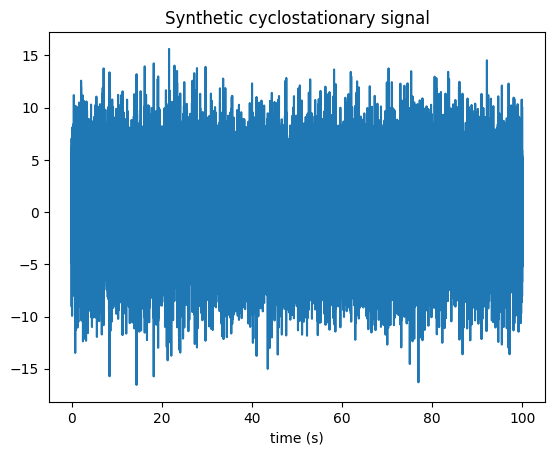

In [70]:
x = np.random.randn(L)

# Filtración por una resonancia
a = [1, -2 * np.cos(2 * np.pi * 0.2) * 0.9, 0.9 ** 2]
x = signal.lfilter([1], a, x)

# Modulación de amplitud periódica
x = x * (1 + np.sin(2 * np.pi * np.arange(L) * f0 / Fs))

# Adición de ruido blanco (SNR = 0dB)
x = x + np.std(x) * np.random.randn(L)

plt.figure()
plt.plot(np.arange(L) / Fs, x)
plt.title('Synthetic cyclostationary signal')
plt.xlabel('time (s)')
plt.show()

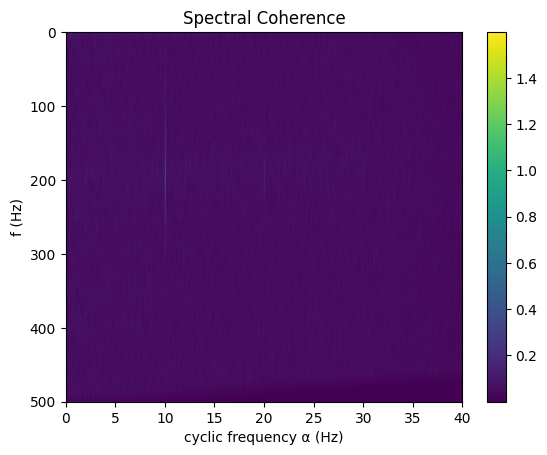

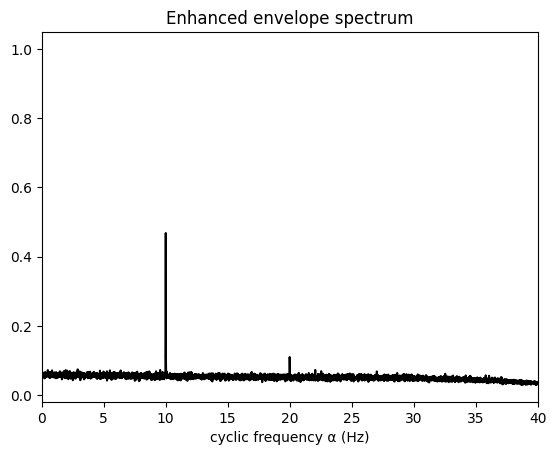

In [71]:
Nw = 2 ** 7 
alpha_max = 4 * f0  
opt = {'abs': 0,'coh': 1,'calib': 0}  
S, alpha, f, _STFT, _t, Nv = fast_sc(x, Nw, alpha_max, Fs, opt)

S = np.squeeze(S, axis=1)

plt.figure()
#plt.subplot(211)
plt.imshow(np.abs(S), aspect='auto', extent=[alpha[1], alpha[-1], f[-1], f[0]], origin='upper')
plt.colorbar()
plt.title('Spectral Coherence' if opt['coh'] else 'Spectral Correlation')
plt.xlabel('cyclic frequency α (Hz)')
plt.ylabel('f (Hz)')
plt.xlim([0, alpha_max])
plt.show()

plt.figure()
#plt.subplot(212)
plt.plot(alpha, np.mean(np.abs(S), axis=0), 'k')
plt.xlim([0, alpha_max])
plt.title('Enhanced envelope spectrum')
plt.xlabel('cyclic frequency α (Hz)')
plt.show()